Lab_2 var_3-3
 

Всякие импорты нужных библиотек


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

Загружаем данные с сайта:

https://keras.io/api/datasets/fashion_mnist/

In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()


Смотрим какие у нас данные


В тренировочных 60к картинок 28 на 28

In [ ]:
train_images.shape

(60000, 28, 28)

In [ ]:
len(train_labels)

60000

У каждой есть метка, представляющая собой целое число в диапозоне от 0 до 9 и показывающая к какому классу относится данная картинка

Метки следующие: 
0.   T-shirt/top
1.   Trouser
2.   Pullover
3.   Dress
4.   Coat
5.   Sandal
6.   Shirt
7.   Sneaker
8.   Bag
9.   Ankle boot

In [ ]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

Для большего удобства (чтобы потом давать цифрам соответствие буков) сделаем переменную, хранящую массив названий меток

In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

В тестовом 10к картинок 28 на 28

In [ ]:
test_images.shape

(10000, 28, 28)

In [ ]:
len(test_labels)

10000

Подготовка данных (изначально значения каждого пикселя от 0 до 255)

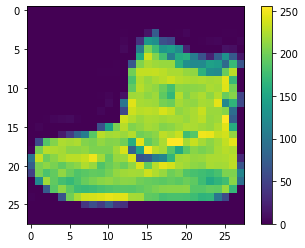

In [ ]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

Нормализуем их так, чтобы значения были от 0 до 1

In [ ]:
train_images = train_images / 255.0

test_images = test_images / 255.0

Выведем первые 25 элементов

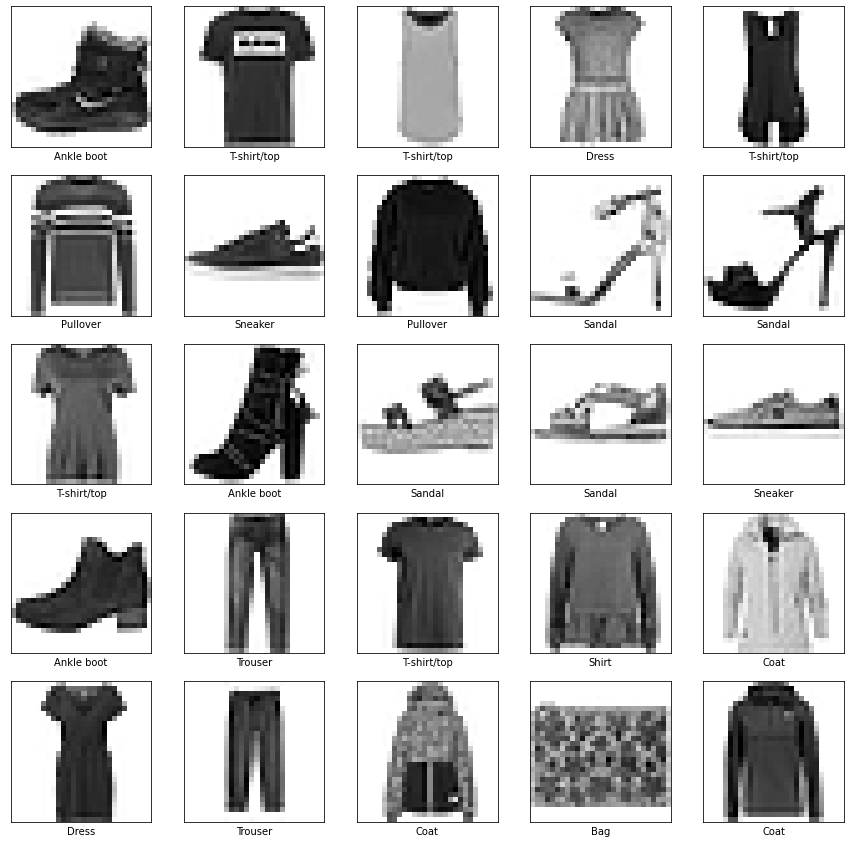

In [ ]:
plt.figure(figsize=(15,15))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary) #, cmap=plt.cm.binary
    plt.xlabel(class_names[train_labels[i]])
plt.show()

Для дальнейшей правильно работы нужно привести данные к формату нейросети (так как сеть принимает на вход массив из 4 элементов, а мы имеем только 3 элемента, нужно добавить значение количества каналов)

In [ ]:
train_images = train_images.reshape(-1, 28, 28, 1)
test_images = test_images.reshape(-1, 28, 28, 1)

Для правильной работы нужно перевести метки из векотора класса целых чисел в двоичную матрицу классов


In [ ]:
from tensorflow.keras.utils import to_categorical 
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

ResNet 18-34

In [ ]:
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
from keras.models import Model, load_model
from keras.initializers import glorot_uniform
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import keras.backend as K
import tensorflow as tf

In [ ]:
def tiny_identity_block(X, f, filters, stage, block):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F = filters

    # Save the input value. We'll need this later to add back to the main path. 
    X_shortcut = X

    # First component of main path
    X = Conv2D(filters = F, kernel_size = (f, f), padding = 'same', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters = F, kernel_size = (f, f), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)


    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [ ]:
def tiny_convolutional_block(X, f, filters, stage, block, s = 2):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(filters=F, kernel_size=(f, f), padding='same', strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters=F, kernel_size=(f, f), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)

    
    ##### SHORTCUT PATH ####
    X_shortcut = Conv2D(F, (1, 1), strides = (s,s), name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [ ]:
def ResNet18(input_shape = (28, 28, 1), classes = 10):   
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = tiny_convolutional_block(X, f = 3, filters = 64, stage = 2, block='a', s = 1)
    X = tiny_identity_block(X, 3, 64, stage=2, block='b')

    # Stage 3
    X = tiny_convolutional_block(X, f = 3, filters = 128, stage = 3, block='a', s = 2)
    X = tiny_identity_block(X, 3, 128, stage=3, block='b')

    # Stage 4
    X = tiny_convolutional_block(X, f = 3, filters = 256, stage = 4, block='a', s = 2)
    X = tiny_identity_block(X, 3, 256, stage=4, block='b')

    # Stage 5
    X = tiny_convolutional_block(X, f = 3, filters = 512, stage = 5, block='a', s = 2)
    X = tiny_identity_block(X, 3, 512, stage=5, block='b')

    # AVGPOOL.
    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet18')

    return model

In [ ]:
def ResNet34(input_shape = (28, 28, 1), classes = 10):   
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = tiny_convolutional_block(X, f = 3, filters = 64, stage = 2, block='a', s = 1)
    X = tiny_identity_block(X, 3, 64, stage=2, block='b')
    X = tiny_identity_block(X, 3, 64, stage=2, block='c')

    # Stage 3
    X = tiny_convolutional_block(X, f = 3, filters = 128, stage = 3, block='a', s = 2)
    X = tiny_identity_block(X, 3, 128, stage=3, block='b')
    X = tiny_identity_block(X, 3, 128, stage=3, block='c')
    X = tiny_identity_block(X, 3, 128, stage=3, block='d')

    # Stage 4
    X = tiny_convolutional_block(X, f = 3, filters = 256, stage = 4, block='a', s = 2)
    X = tiny_identity_block(X, 3, 256, stage=4, block='b')
    X = tiny_identity_block(X, 3, 256, stage=4, block='c')
    X = tiny_identity_block(X, 3, 256, stage=4, block='d')
    X = tiny_identity_block(X, 3, 256, stage=4, block='e')
    X = tiny_identity_block(X, 3, 256, stage=4, block='f')

    # Stage 5
    X = tiny_convolutional_block(X, f = 3, filters = 512, stage = 5, block='a', s = 2)
    X = tiny_identity_block(X, 3, 512, stage=5, block='b')
    X = tiny_identity_block(X, 3, 512, stage=5, block='c')

    # AVGPOOL.
    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet34')

    return model

ResNet 50-101-152


In [ ]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    
    ##### SHORTCUT PATH ####
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [ ]:
def identity_block(X, f, filters, stage, block):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value. We'll need this later to add back to the main path. 
    X_shortcut = X

    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [ ]:
def ResNet50(input_shape = (28, 28, 1), classes = 10):   
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    # Stage 3
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL.
    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [ ]:
def ResNet101(input_shape = (28, 28, 1), classes = 10):   
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    # Stage 3
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='g')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='h')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='i')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='j')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='k')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='l')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='m')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='n')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='o')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='p')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='q')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='r')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='s')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='t')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='u')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='v')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='w')

    # Stage 5
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL.
    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet101')

    return model

In [ ]:
def ResNet152(input_shape = (28, 28, 1), classes = 10):   
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    # Stage 3
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='e')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='f')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='g')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='h')

    # Stage 4
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='g')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='h')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='i')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='j')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='k')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='l')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='m')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='n')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='o')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='p')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='q')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='r')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='s')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='t')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='u')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='v')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='w')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='x')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='y')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='z')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='aa')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='bb')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='cc')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='dd')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='ee')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='ff')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='gg')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='hh')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='ii')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='jj')


    # Stage 5
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL.
    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet152')

    return model

Тестирование моделей

In [ ]:
model_18 = ResNet18(input_shape = (28, 28, 1), classes = 10)

In [ ]:
model_34 = ResNet34(input_shape = (28, 28, 1), classes = 10)

In [ ]:
model_50 = ResNet50(input_shape = (28, 28, 1), classes = 10)

In [ ]:
model_101 = ResNet101(input_shape = (28, 28, 1), classes = 10)

In [ ]:
model_152 = ResNet152(input_shape = (28, 28, 1), classes = 10)

In [ ]:
model_18.summary()

Model: "ResNet18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 34, 34, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 14, 14, 64)   3200        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 14, 14, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

Компиляция модели

In [ ]:
model_18.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss="categorical_crossentropy", metrics=['categorical_accuracy'])

In [ ]:
model_34.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss="categorical_crossentropy", metrics=['categorical_accuracy'])

In [ ]:
model_50.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss="categorical_crossentropy", metrics=['categorical_accuracy'])

In [ ]:
model_101.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss="categorical_crossentropy", metrics=['categorical_accuracy'])

In [ ]:
model_152.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss="categorical_crossentropy", metrics=['categorical_accuracy'])

Обучение модели

In [ ]:
history = model_18.fit(train_images, train_labels,  epochs=15, batch_size=128, validation_split=0.2, verbose=1, shuffle = True)

Epoch 1/15
375/375 [==============================] - 30s 69ms/step - loss: 0.4974 - categorical_accuracy: 0.8248 - val_loss: 2.2409 - val_categorical_accuracy: 0.3579
Epoch 2/15
375/375 [==============================] - 25s 67ms/step - loss: 0.3143 - categorical_accuracy: 0.8848 - val_loss: 0.3888 - val_categorical_accuracy: 0.8629
Epoch 3/15
375/375 [==============================] - 25s 67ms/step - loss: 0.2682 - categorical_accuracy: 0.8997 - val_loss: 0.3320 - val_categorical_accuracy: 0.8748
Epoch 4/15
375/375 [==============================] - 25s 67ms/step - loss: 0.2408 - categorical_accuracy: 0.9105 - val_loss: 0.3170 - val_categorical_accuracy: 0.8846
Epoch 5/15
375/375 [==============================] - 25s 66ms/step - loss: 0.2159 - categorical_accuracy: 0.9197 - val_loss: 0.2798 - val_categorical_accuracy: 0.8997
Epoch 6/15
375/375 [==============================] - 25s 67ms/step - loss: 0.1938 - categorical_accuracy: 0.9276 - val_loss: 0.4295 - val_categorical_accuracy:

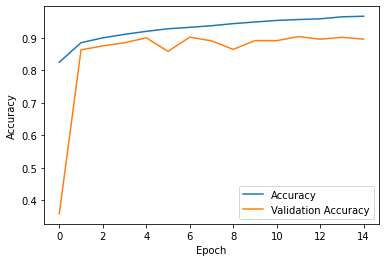

In [ ]:
plt.plot(history.history['categorical_accuracy'], label = 'Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Распечатываем карту признаков

In [ ]:
activation_model = Model(inputs=model_18.input, outputs=model_18.layers[2].output)

In [ ]:
img_arr = train_images[0]
img_arr = np.expand_dims(img_arr, axis = 0)

In [ ]:
activation = activation_model.predict(img_arr)

In [ ]:
print(activation.shape)

(1, 14, 14, 64)


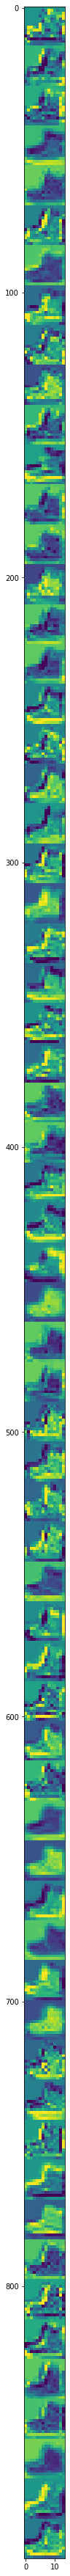

In [ ]:
images_per_row = 1
n_filtres = activation.shape[-1]
size = activation.shape[1]
n_cols = n_filtres
display_grid = np.zeros((n_cols * size, images_per_row * size))
for col in range(n_cols):
  for row in range(images_per_row):
    channel_image = activation[0, :, :, col * images_per_row + row]
    channel_image -= channel_image.mean()
    channel_image /= channel_image.std()
    channel_image *= 64
    channel_image += 128
    channel_image = np.clip(channel_image, 0, 255).astype('uint8')
    display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image
scale = 1. /size
plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
plt.grid(False)
plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [ ]:
activation_model = Model(inputs=model_18.input, outputs=model_18.layers[65].output)

In [ ]:
activation = activation_model.predict(img_arr)

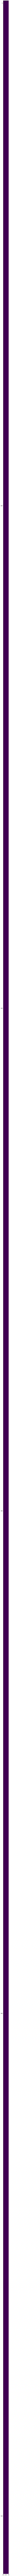

In [ ]:
images_per_row = 1
n_filtres = activation.shape[-1]
size = activation.shape[1]
n_cols = n_filtres
display_grid = np.zeros((n_cols * size, images_per_row * size))
for col in range(n_cols):
  for row in range(images_per_row):
    channel_image = activation[0, :, :, col * images_per_row + row]
    channel_image -= channel_image.mean()
    channel_image /= channel_image.std()
    channel_image *= 64
    channel_image += 128
    channel_image = np.clip(channel_image, 0, 255).astype('uint8')
    display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image
scale = 1. /size
plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
plt.grid(False)
plt.imshow(display_grid, aspect='auto', cmap='viridis')

Тестирование других моделей

In [ ]:
history = model_34.fit(train_images, train_labels,  epochs=15, batch_size=128, validation_split=0.2, verbose=1, shuffle = True)

Epoch 1/15
375/375 [==============================] - 48s 116ms/step - loss: 0.5482 - categorical_accuracy: 0.8059 - val_loss: 1.6660 - val_categorical_accuracy: 0.4691
Epoch 2/15
375/375 [==============================] - 42s 113ms/step - loss: 0.3350 - categorical_accuracy: 0.8770 - val_loss: 0.4327 - val_categorical_accuracy: 0.8403
Epoch 3/15
375/375 [==============================] - 42s 113ms/step - loss: 0.2835 - categorical_accuracy: 0.8970 - val_loss: 0.3712 - val_categorical_accuracy: 0.8701
Epoch 4/15
375/375 [==============================] - 42s 113ms/step - loss: 0.2483 - categorical_accuracy: 0.9076 - val_loss: 0.3409 - val_categorical_accuracy: 0.8840
Epoch 5/15
375/375 [==============================] - 42s 113ms/step - loss: 0.2268 - categorical_accuracy: 0.9157 - val_loss: 0.3466 - val_categorical_accuracy: 0.8719
Epoch 6/15
375/375 [==============================] - 42s 113ms/step - loss: 0.2078 - categorical_accuracy: 0.9230 - val_loss: 0.3573 - val_categorical_acc

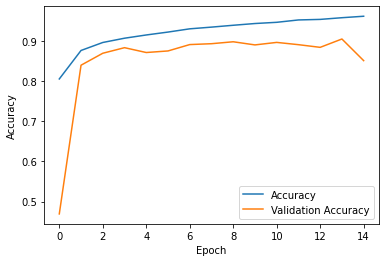

In [ ]:
plt.plot(history.history['categorical_accuracy'], label = 'Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
history = model_50.fit(train_images, train_labels,  epochs=15, batch_size=128, validation_split=0.2, verbose=1, shuffle = True)


Epoch 1/15
375/375 [==============================] - 56s 130ms/step - loss: 0.6479 - categorical_accuracy: 0.7728 - val_loss: 1.4019 - val_categorical_accuracy: 0.4942
Epoch 2/15
375/375 [==============================] - 47s 126ms/step - loss: 0.3724 - categorical_accuracy: 0.8640 - val_loss: 0.4102 - val_categorical_accuracy: 0.8554
Epoch 3/15
375/375 [==============================] - 47s 126ms/step - loss: 0.3066 - categorical_accuracy: 0.8876 - val_loss: 0.3871 - val_categorical_accuracy: 0.8528
Epoch 4/15
375/375 [==============================] - 47s 126ms/step - loss: 0.2721 - categorical_accuracy: 0.9000 - val_loss: 0.3790 - val_categorical_accuracy: 0.8651
Epoch 5/15
375/375 [==============================] - 47s 127ms/step - loss: 0.2478 - categorical_accuracy: 0.9098 - val_loss: 0.3597 - val_categorical_accuracy: 0.8720
Epoch 6/15
375/375 [==============================] - 47s 126ms/step - loss: 0.2316 - categorical_accuracy: 0.9149 - val_loss: 0.3308 - val_categorical_acc

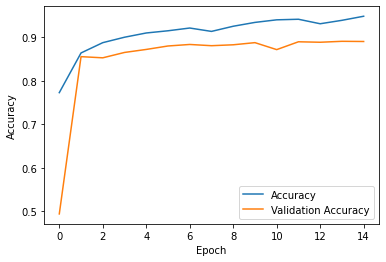

In [ ]:
plt.plot(history.history['categorical_accuracy'], label = 'Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
history = model_101.fit(train_images, train_labels,  epochs=15, batch_size=128, validation_split=0.2, verbose=1, shuffle = True)

Epoch 1/15
375/375 [==============================] - 101s 239ms/step - loss: 0.6973 - categorical_accuracy: 0.7529 - val_loss: 1.4232 - val_categorical_accuracy: 0.5201
Epoch 2/15
375/375 [==============================] - 88s 234ms/step - loss: 0.4043 - categorical_accuracy: 0.8535 - val_loss: 0.4210 - val_categorical_accuracy: 0.8518
Epoch 3/15
375/375 [==============================] - 88s 234ms/step - loss: 0.3306 - categorical_accuracy: 0.8804 - val_loss: 0.4011 - val_categorical_accuracy: 0.8569
Epoch 4/15
375/375 [==============================] - 88s 234ms/step - loss: 0.2829 - categorical_accuracy: 0.8961 - val_loss: 0.3804 - val_categorical_accuracy: 0.8646
Epoch 5/15
375/375 [==============================] - 88s 234ms/step - loss: 0.2631 - categorical_accuracy: 0.9023 - val_loss: 0.3777 - val_categorical_accuracy: 0.8671
Epoch 6/15
375/375 [==============================] - 88s 234ms/step - loss: 0.2369 - categorical_accuracy: 0.9126 - val_loss: 0.3682 - val_categorical_ac

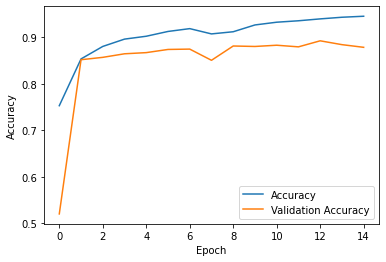

In [ ]:
plt.plot(history.history['categorical_accuracy'], label = 'Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
history = model_152.fit(train_images, train_labels,  epochs=5, batch_size=128, validation_split=0.2, verbose=1, shuffle = True)

Epoch 1/5
375/375 [==============================] - 129s 344ms/step - loss: 0.5786 - categorical_accuracy: 0.7900 - val_loss: 1.2535 - val_categorical_accuracy: 0.5287
Epoch 2/5
375/375 [==============================] - 126s 336ms/step - loss: 0.4034 - categorical_accuracy: 0.8553 - val_loss: 0.4340 - val_categorical_accuracy: 0.8461
Epoch 3/5
375/375 [==============================] - 126s 336ms/step - loss: 0.3343 - categorical_accuracy: 0.8778 - val_loss: 0.4103 - val_categorical_accuracy: 0.8508
Epoch 4/5
375/375 [==============================] - 126s 336ms/step - loss: 0.2931 - categorical_accuracy: 0.8935 - val_loss: 0.4119 - val_categorical_accuracy: 0.8646
Epoch 5/5
375/375 [==============================] - 126s 336ms/step - loss: 0.2626 - categorical_accuracy: 0.9064 - val_loss: 0.4452 - val_categorical_accuracy: 0.8528


In [ ]:
print('Время 4 часа ночи, хочеца спать...')

Время 4 часа ночи, хочеца спать...


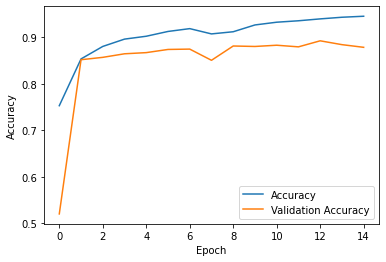

In [ ]:
plt.plot(history.history['categorical_accuracy'], label = 'Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Оценка точности

In [ ]:
preds1 = model_18.evaluate(test_images, test_labels)
print ("Loss = " + str(preds1[0]))
print ("Test Accuracy = " + str(preds1[1]))

313/313 [==============================] - 5s 15ms/step - loss: 0.4266 - categorical_accuracy: 0.8926
Loss = 0.42662227153778076
Test Accuracy = 0.8925999999046326


In [ ]:
preds2 = model_34.evaluate(test_images, test_labels)
print ("Loss = " + str(preds2[0]))
print ("Test Accuracy = " + str(preds2[1]))

313/313 [==============================] - 8s 24ms/step - loss: 0.5706 - categorical_accuracy: 0.8459
Loss = 0.5706315636634827
Test Accuracy = 0.8458999991416931


In [ ]:
preds3 = model_50.evaluate(test_images, test_labels)
print ("Loss = " + str(preds3[0]))
print ("Test Accuracy = " + str(preds3[1]))

313/313 [==============================] - 9s 27ms/step - loss: 0.3637 - categorical_accuracy: 0.8862
Loss = 0.3637114465236664
Test Accuracy = 0.8862000107765198


In [ ]:
preds4 = model_101.evaluate(test_images, test_labels)
print ("Loss = " + str(preds4[0]))
print ("Test Accuracy = " + str(preds4[1]))

313/313 [==============================] - 15s 48ms/step - loss: 0.4100 - categorical_accuracy: 0.8756
Loss = 0.40998658537864685
Test Accuracy = 0.8755999803543091


In [ ]:
preds5 = model_152.evaluate(test_images, test_labels)
print ("Loss = " + str(preds5[0]))
print ("Test Accuracy = " + str(preds5[1]))

313/313 [==============================] - 21s 68ms/step - loss: 0.4677 - categorical_accuracy: 0.8511
Loss = 0.46766430139541626
Test Accuracy = 0.8511000275611877


Итого лучшая модель - ResNet 18

In [ ]:
model = model_18

Распечатка всех слоёв

In [ ]:
for layer in model.layers:
    layer.trainable = False

In [ ]:
for layer in model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7efc71680f50> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7efc7212ce90> False
<keras.layers.convolutional.Conv2D object at 0x7efc7169f210> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7efc6fd94290> False
<keras.layers.core.Activation object at 0x7efc6fdc0b10> False
<keras.layers.pooling.MaxPooling2D object at 0x7efc600d9fd0> False
<keras.layers.convolutional.Conv2D object at 0x7efc600acf90> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7efc71641d90> False
<keras.layers.core.Activation object at 0x7efc6008a110> False
<keras.layers.convolutional.Conv2D object at 0x7efc600a1050> False
<keras.layers.convolutional.Conv2D object at 0x7efc60029790> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7efc60097dd0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7efc6002d1d0> False
<k

Предсказание

In [ ]:
predicted_labels = model.predict(test_images)

In [ ]:
predicted_labels

array([[1.04627494e-10, 9.91701499e-10, 2.40558212e-10, ...,
        1.26513362e-06, 8.53740367e-09, 9.99987483e-01],
       [1.17298559e-05, 8.31114289e-09, 9.99819219e-01, ...,
        2.84090396e-09, 3.53250186e-07, 2.04661390e-08],
       [2.42560851e-08, 9.99999046e-01, 6.92165170e-09, ...,
        3.91408364e-11, 3.01248804e-07, 3.18635309e-12],
       ...,
       [8.58340776e-09, 4.18137414e-10, 8.36160363e-10, ...,
        3.77263165e-10, 1.00000000e+00, 1.75691701e-11],
       [6.65180341e-11, 1.00000000e+00, 1.37718137e-09, ...,
        7.13019010e-12, 4.78532014e-09, 8.07721335e-14],
       [9.61645347e-11, 3.08335774e-10, 3.10123455e-10, ...,
        3.08999188e-05, 9.15116561e-06, 2.21723848e-08]], dtype=float32)

In [ ]:
test_images = test_images.reshape(-1, 28, 28)

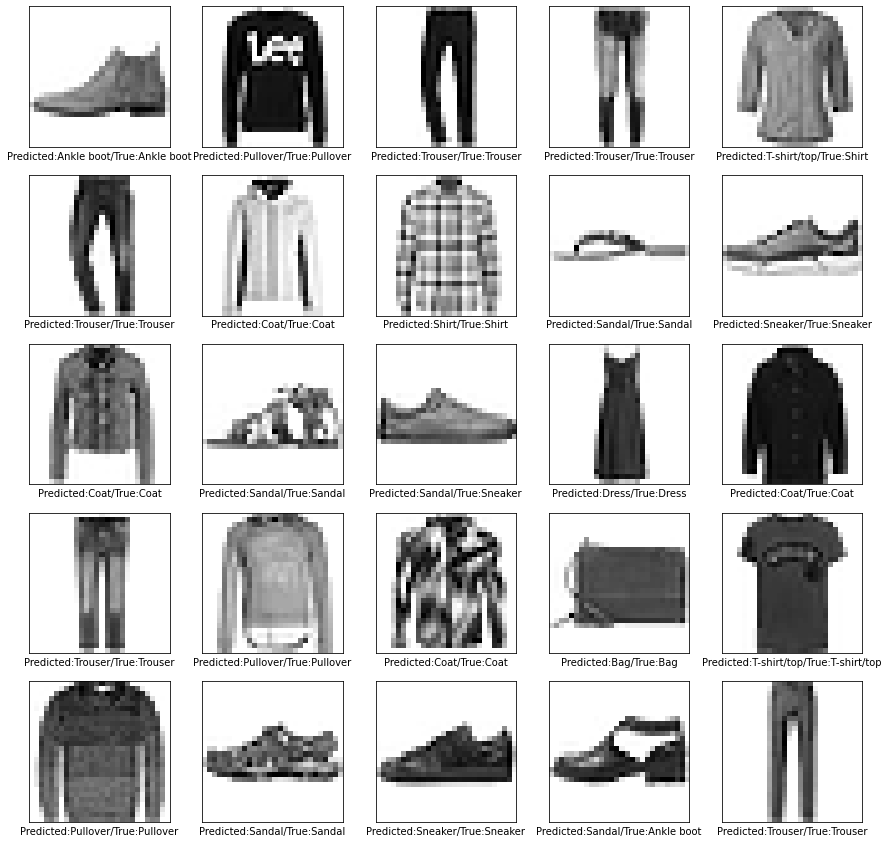

In [ ]:
plt.figure(figsize=(15,15))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[i], cmap=plt.cm.binary) #, cmap=plt.cm.binary
    plt.xlabel('Predicted:' + class_names[np.argmax(predicted_labels[i])]+ '/True:' + class_names[np.argmax(test_labels[i])])
plt.show()

Добавляем шум к фотографиям 


In [ ]:
def add_uniform_noise(signal, snr):
    ''' 
    signal: np.ndarray
    snr: float

    returns -> np.ndarray
    '''

    mu, sigma = 3, 0.1
    noise = np.random.uniform(mu, sigma, signal.shape)

    # Generate the noise as you did
    #noise = acoustics.generator.white(signal.size).reshape(*signal.shape)
    # For the record I think np.random.random does exactly the same thing

    # work out the current SNR
    current_snr = np.mean(signal) / np.std(noise)

    # scale the noise by the snr ratios (smaller noise <=> larger snr)
    noise *= (current_snr / snr)

    # return the new signal with noise
    return signal + noise

In [ ]:
def add_normal_noise(signal, snr):
    ''' 
    signal: np.ndarray
    snr: float

    returns -> np.ndarray
    '''

    mu, sigma = 3, 0.1
    noise = np.random.normal(mu, sigma, signal.shape)

    # Generate the noise as you did
    #noise = acoustics.generator.white(signal.size).reshape(*signal.shape)
    # For the record I think np.random.random does exactly the same thing

    # work out the current SNR
    current_snr = np.mean(signal) / np.std(noise)

    # scale the noise by the snr ratios (smaller noise <=> larger snr)
    noise *= (current_snr / snr)

    # return the new signal with noise
    return signal + noise

In [ ]:
Num_of_noise_frames = 10000

Равномерный шум ОСШ = 5

In [ ]:
uniform_5_test_images = np.zeros((Num_of_noise_frames, 28, 28))
for i in range(Num_of_noise_frames):
    uniform_5_test_images[i] = add_uniform_noise(test_images[i], 5)

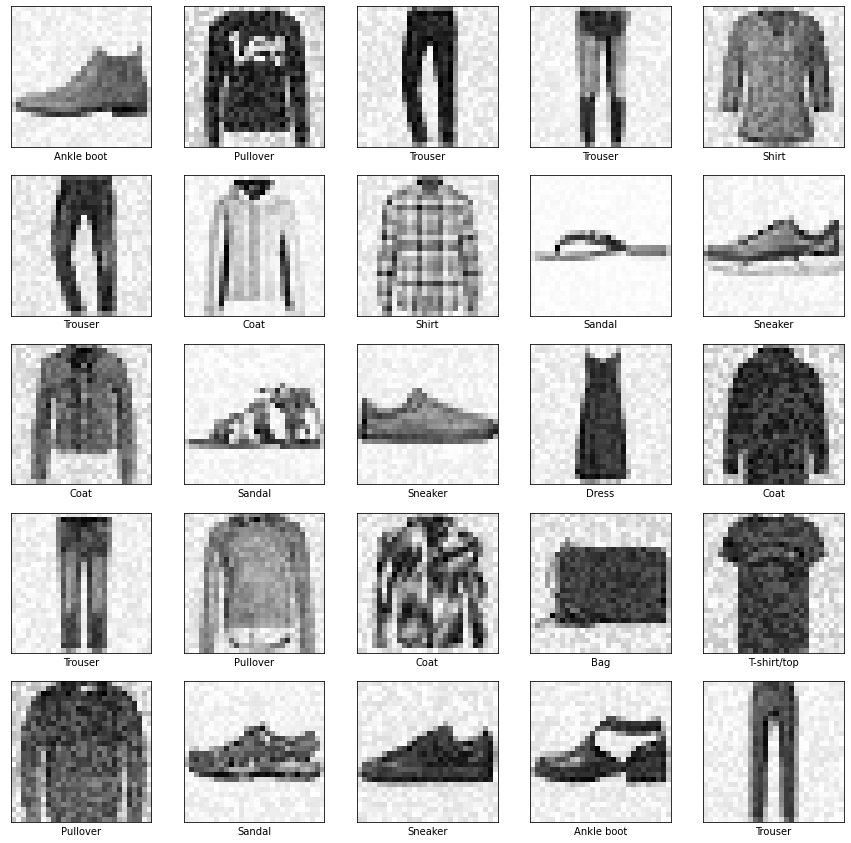

In [ ]:
plt.figure(figsize=(15,15))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(uniform_5_test_images[i], cmap=plt.cm.binary) #, cmap=plt.cm.binary
    plt.xlabel(class_names[np.argmax(test_labels[i])])
plt.show()

In [ ]:
uniform_5_predicted_labels = model.predict(uniform_5_test_images)

In [ ]:
preds = model.evaluate(uniform_5_test_images, test_labels[0:Num_of_noise_frames])
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

313/313 [==============================] - 5s 15ms/step - loss: 0.5574 - categorical_accuracy: 0.8582
Loss = 0.5574393272399902
Test Accuracy = 0.8582000136375427


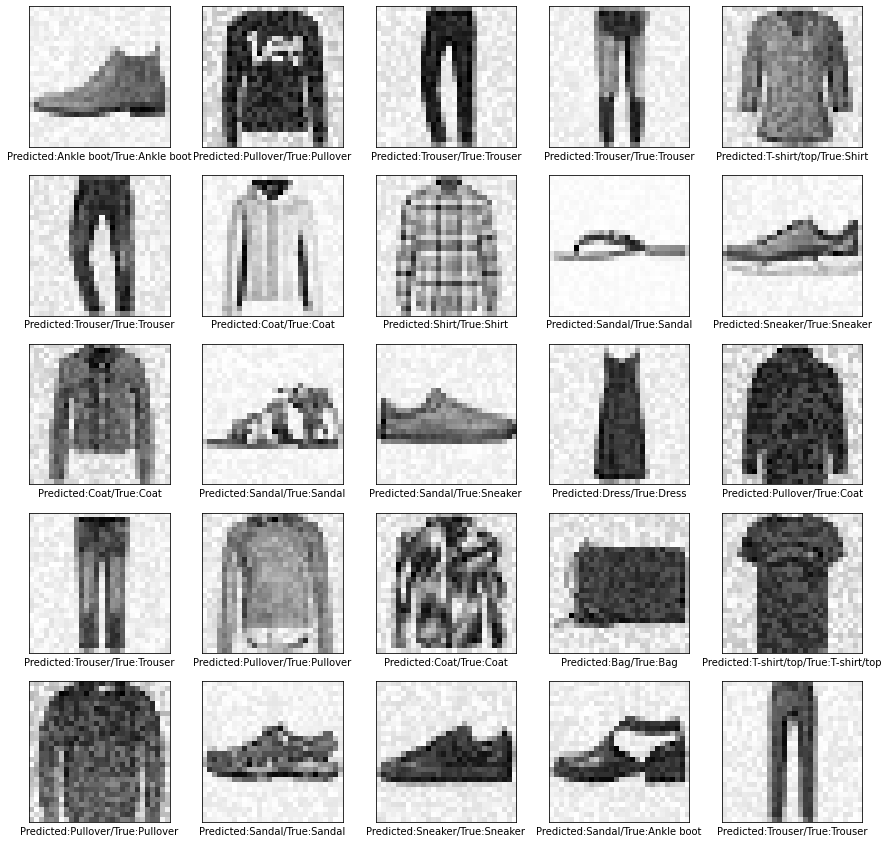

In [ ]:
plt.figure(figsize=(15,15))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(uniform_5_test_images[i], cmap=plt.cm.binary) #, cmap=plt.cm.binary
    plt.xlabel('Predicted:' + class_names[np.argmax(uniform_5_predicted_labels[i])]+ '/True:' + class_names[np.argmax(test_labels[i])])
plt.show()

Равномерный шум ОСШ = 20

In [ ]:
uniform_20_test_images = np.zeros((Num_of_noise_frames, 28, 28))
for i in range(Num_of_noise_frames):
    uniform_20_test_images[i] = add_uniform_noise(test_images[i], 20)

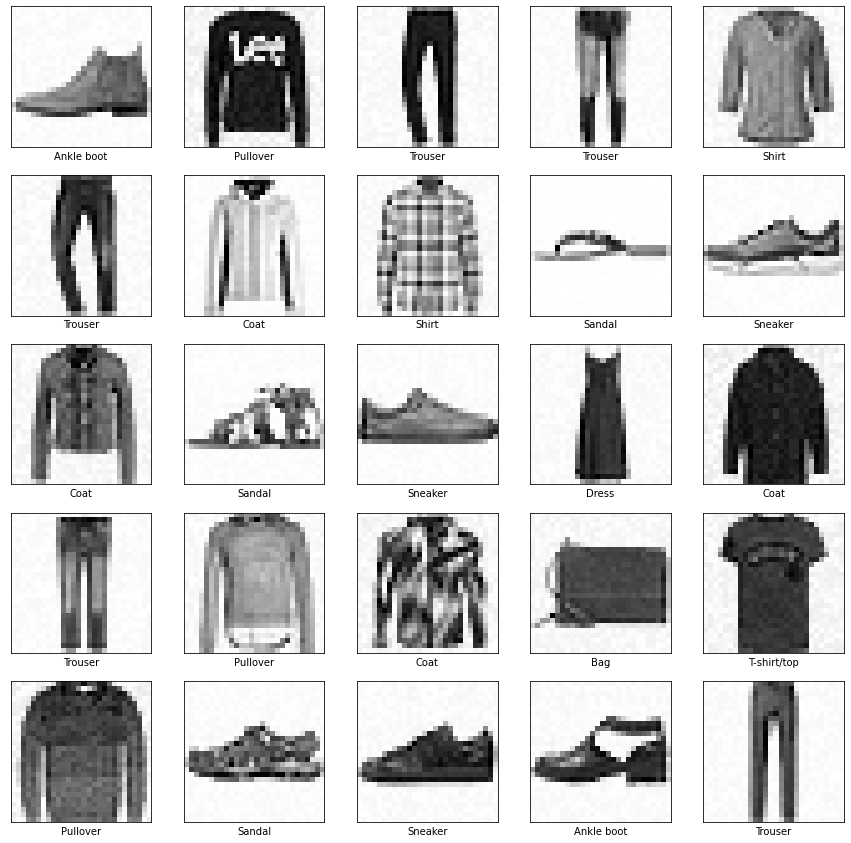

In [ ]:
plt.figure(figsize=(15,15))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(uniform_20_test_images[i], cmap=plt.cm.binary) #, cmap=plt.cm.binary
    plt.xlabel(class_names[np.argmax(test_labels[i])])
plt.show()

In [ ]:
uniform_20_predicted_labels = model.predict(uniform_20_test_images)

In [ ]:
preds = model.evaluate(uniform_20_test_images, test_labels[0:Num_of_noise_frames])
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

313/313 [==============================] - 5s 15ms/step - loss: 0.4401 - categorical_accuracy: 0.8897
Loss = 0.440081924200058
Test Accuracy = 0.8896999955177307


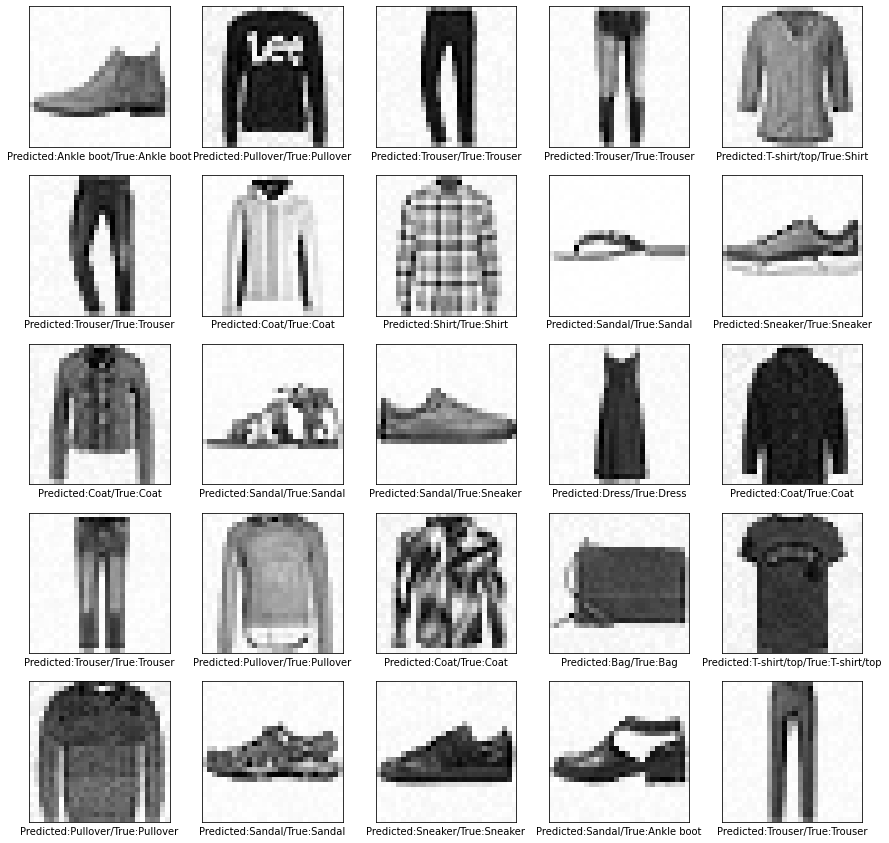

In [ ]:
plt.figure(figsize=(15,15))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(uniform_20_test_images[i], cmap=plt.cm.binary) #, cmap=plt.cm.binary
    plt.xlabel('Predicted:' + class_names[np.argmax(uniform_20_predicted_labels[i])]+ '/True:' + class_names[np.argmax(test_labels[i])])
plt.show()

Нормальный шум ОСШ = 5


In [ ]:
normal_5_test_images = np.zeros((Num_of_noise_frames, 28, 28))
for i in range(Num_of_noise_frames):
    normal_5_test_images[i] = add_normal_noise(test_images[i], 5)

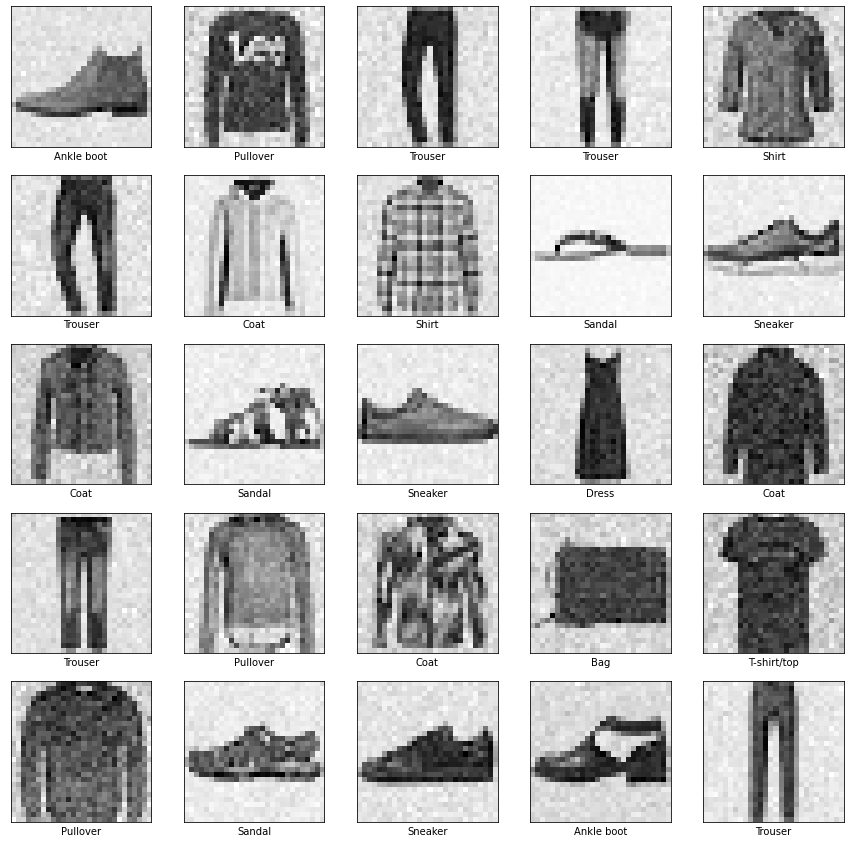

In [ ]:
plt.figure(figsize=(15,15))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(normal_5_test_images[i], cmap=plt.cm.binary) #, cmap=plt.cm.binary
    plt.xlabel(class_names[np.argmax(test_labels[i])])
plt.show()

In [ ]:
normal_5_predicted_labels = model.predict(normal_5_test_images)

In [ ]:
preds = model.evaluate(normal_5_test_images, test_labels[0:Num_of_noise_frames])
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

313/313 [==============================] - 5s 15ms/step - loss: 5.0146 - categorical_accuracy: 0.1476
Loss = 5.0146331787109375
Test Accuracy = 0.147599995136261


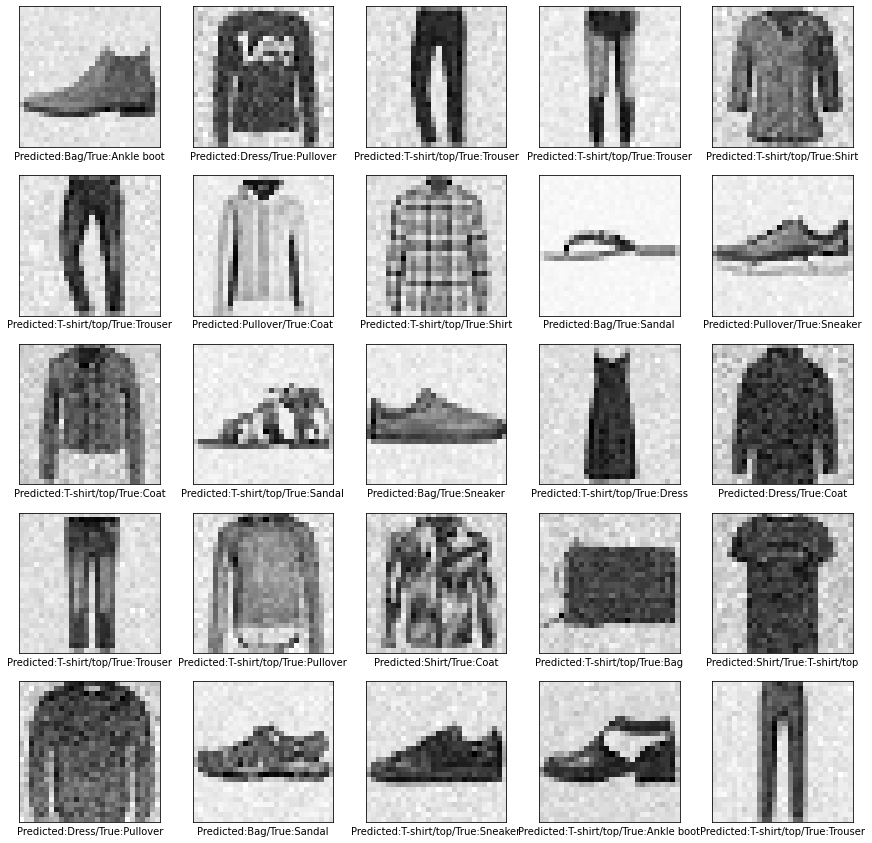

In [ ]:
plt.figure(figsize=(15,15))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(normal_5_test_images[i], cmap=plt.cm.binary) #, cmap=plt.cm.binary
    plt.xlabel('Predicted:' + class_names[np.argmax(normal_5_predicted_labels[i])]+ '/True:' + class_names[np.argmax(test_labels[i])])
plt.show()

Нормальный шум ОСШ = 20

In [ ]:
normal_20_test_images = np.zeros((Num_of_noise_frames, 28, 28))
for i in range(Num_of_noise_frames):
    normal_20_test_images[i] = add_normal_noise(test_images[i], 20)

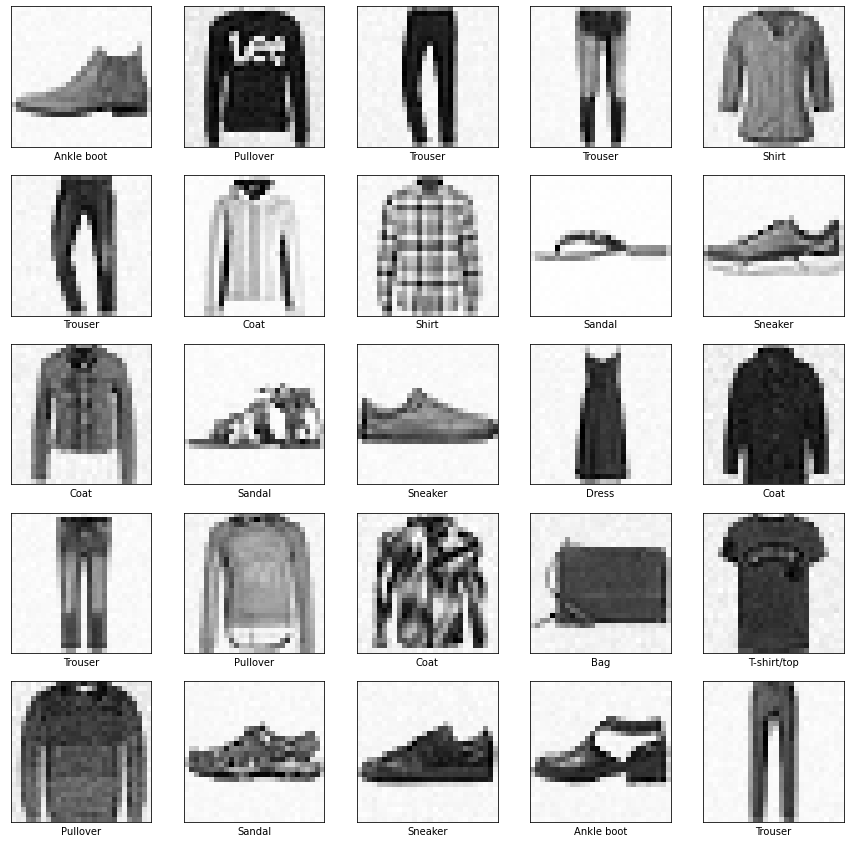

In [ ]:
plt.figure(figsize=(15,15))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(normal_20_test_images[i], cmap=plt.cm.binary) #, cmap=plt.cm.binary
    plt.xlabel(class_names[np.argmax(test_labels[i])])
plt.show()

In [ ]:
normal_20_predicted_labels = model.predict(normal_20_test_images)

In [ ]:
preds = model.evaluate(normal_20_test_images, test_labels[0:Num_of_noise_frames])
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

313/313 [==============================] - 5s 15ms/step - loss: 1.6096 - categorical_accuracy: 0.6244
Loss = 1.6096478700637817
Test Accuracy = 0.6244000196456909


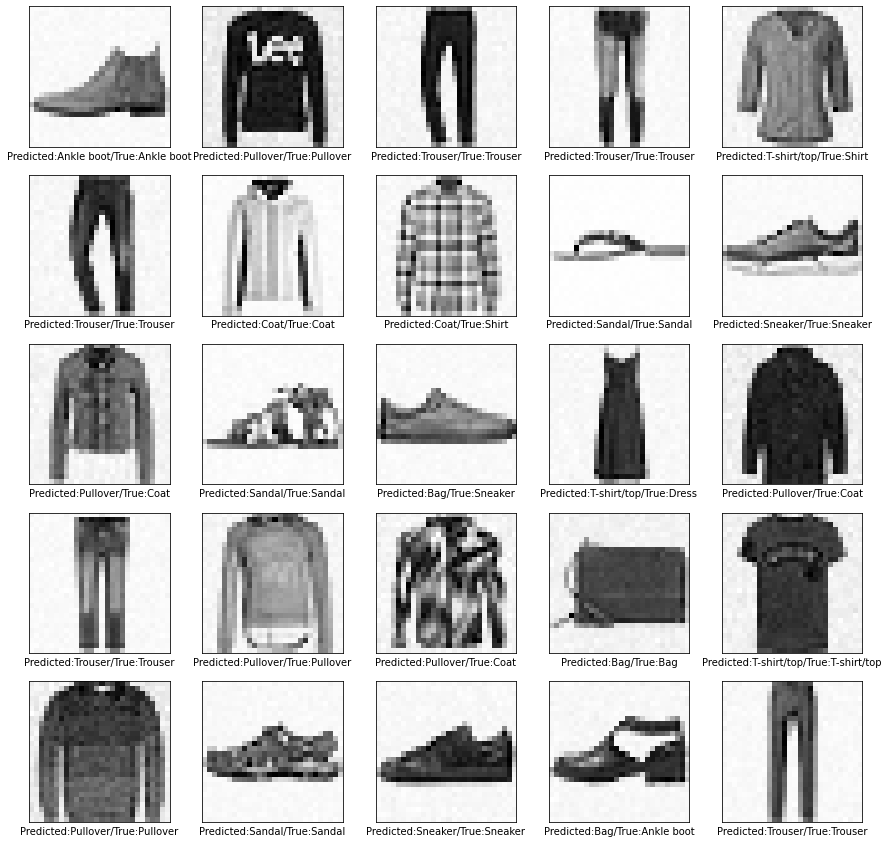

In [ ]:
plt.figure(figsize=(15,15))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(normal_20_test_images[i], cmap=plt.cm.binary) #, cmap=plt.cm.binary
    plt.xlabel('Predicted:' + class_names[np.argmax(normal_20_predicted_labels[i])]+ '/True:' + class_names[np.argmax(test_labels[i])])
plt.show()

Ссылки на статьи:

https://pylessons.com/Keras-ResNet-tutorial/ - реализация ResNet50 на Keras (взял эту)

https://www.analyticsvidhya.com/blog/2021/08/how-to-code-your-resnet-from-scratch-in-tensorflow/ - реализация ResNet34 на Keras (взял эту)

https://machinelearningknowledge.ai/keras-implementation-of-resnet-50-architecture-from-scratch/ - ещё одна реализация ResNet на Keras (почему-то оказалась нерабочей, возможно из-за моих косяков по приведению данных, но был 0 loss и точность в 10%)

https://habr.com/ru/post/454034/ - базовая классификация одежды на Fashion Mnist

https://neurohive.io/ru/vidy-nejrosetej/resnet-34-50-101/ - неплохая статья по ResNet 

https://proglib.io/p/issleduem-arhitektury-svertochnyh-neyronnyh-setey-s-pomoshchyu-fast-ai-2020-12-28 - ещё одна статья по ResNet и его производным

https://programmersought.com/article/58886025558/ - реализация всех ResNet




Задание: 

1 Часть

Изучение сети и набора данных.
Выполнить анализ статьи, разобрать структуру сети, принести распечатанную статью,
подготовить презентацию по структуре сети и набору данных, написать код по загрузке 
набора данных в Google Colab и визуализации части изображений из набора данных
Подготовка презентации по описанию сети допустимо в группах. Обратите внимание
что для разбора даны архитекутры, которые достаточно известны и следовательно имеют
описание на русском языке. Способ загрузки: сделайте zip архив, загрузите его в google drive,
разархивируйте архив (!unzip -uq "/content/drive/My Drive/PATH_TO_ZIP" -d "/content/drive/My Drive/PATH_TO_OUTPUT"
), используйте генератор для передачи данных в нейронную сеть (для этого
можно использовать сеть с любой архитекутрой, даже самой простой, цель - проверить загрузку данных).


2 часть

Программная реализация структуры сети. 
По результатам выполнения первой части задания определить структурный элемент сети. Построить несколько вариантов сетей
с разным числом структурных элементов. Для загрузки данных использовать генератор. Зашумить изображения для теста (нормальный, равномерный шум, ОСШ - 5, 20 дБ), оценить точность. Сравнить полученные результаты с известными результатами по точности. Визуализировать карту признаков и ядра свёртки для разных слоёв одного вариантов из обученных сетей. Все результаты экспериментов должны быть сохранены, должна быть выбрана архитекутра сети, обеспечивающая наилучшую точность распознавания, показаны результаты экспериментов по разным архитектурам. По результатам должна быть оформлена презентация.
